In [1]:
# default_exp inferno

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

# Network

In [4]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [5]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.4917e-04, 2.3297e-06, 9.6229e-10, 4.1842e-05, 9.9766e-01, 4.7732e-15,
          1.3315e-09, 6.6304e-18, 2.1127e-03, 3.2967e-05]]),
 tensor([[9.3715e-02, 4.0788e-02, 8.5849e-03, 7.2677e-02, 5.4560e-01, 7.4617e-04,
          9.1610e-03, 2.0016e-04, 1.5924e-01, 6.9293e-02]]),
 tensor([[0.1271, 0.0839, 0.0385, 0.1119, 0.3067, 0.0113, 0.0397, 0.0059, 0.1657,
          0.1093]]))

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

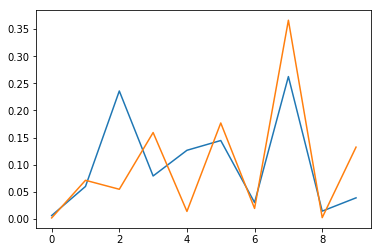

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:       
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad():
            alpha /= 10
            alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
        return ikk
        
    def on_forwards_end(self) -> None:
        
    
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [7]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [17]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=True, n_steps=10, r_mods=None, l_mods=None),LossTracker(),SaveBest('weights/best_ii0a.h5'),EarlyStopping(10)])

1: Train=626.3401806640625 Valid=529.9964752197266
2: Train=370.10445526123044 Valid=350.64888671875
3: Train=344.43535095214844 Valid=344.1530828857422
4: Train=339.3972671508789 Valid=340.26970947265625
5: Train=336.0900164794922 Valid=337.2882873535156
6: Train=333.0647380065918 Valid=334.4262298583984
7: Train=330.46887847900393 Valid=331.9386267089844
8: Train=328.22082092285154 Valid=329.64119323730466
9: Train=326.0012457275391 Valid=327.15819946289065
10: Train=323.9324307250977 Valid=325.14184326171875
11: Train=321.7532690429687 Valid=323.1564434814453
12: Train=319.7590451049805 Valid=321.2807855224609
13: Train=317.67720886230467 Valid=319.24077575683594
14: Train=315.81190399169924 Valid=317.0778521728516
15: Train=313.77073944091796 Valid=315.30760009765623
16: Train=311.7246682739258 Valid=313.3286767578125
17: Train=309.7378399658203 Valid=311.32849548339846
18: Train=308.03697784423827 Valid=309.43910522460936
19: Train=305.9623745727539 Valid=307.32773742675784
20: Tr

156: Train=261.3805848693848 Valid=263.9233740234375
157: Train=261.47246841430666 Valid=263.82851776123044
158: Train=261.10073165893556 Valid=263.8129666137695
159: Train=261.04302154541017 Valid=263.643850402832
160: Train=260.9994584655762 Valid=263.4999053955078
161: Train=260.886270904541 Valid=263.390012512207
162: Train=260.69183959960935 Valid=263.2963092041016
163: Train=260.5748239135742 Valid=263.01437896728515
164: Train=260.54980926513673 Valid=262.9194497680664
165: Train=260.40995208740236 Valid=262.74554840087893
166: Train=260.2610580444336 Valid=262.6500015258789
167: Train=260.22787902832033 Valid=262.39217468261717
168: Train=260.0598359680176 Valid=262.3435662841797
169: Train=259.9192890930176 Valid=262.21681427001954
170: Train=259.7611312866211 Valid=262.1994955444336
171: Train=259.8094499206543 Valid=262.04247314453124
172: Train=259.6959066772461 Valid=261.81250244140625
173: Train=259.69206268310546 Valid=261.6894302368164
174: Train=259.2519703674316 Valid

In [18]:
model.save('weights/Inferno_Test_interp_bm0a.h5')

In [8]:
model.load('weights/Inferno_Test_interp_bm0a.h5')

# Results

In [9]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,7,1.0
1,0,1.0
2,3,1.0
3,7,1.0
4,0,1.0


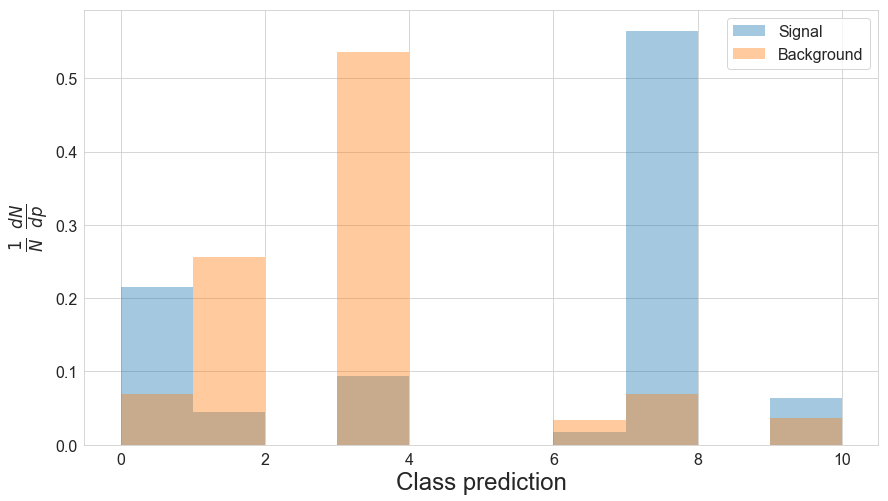

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [12]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,3,1.0,3
1,3,1.0,3
2,0,1.0,0
3,7,1.0,7
4,3,1.0,3


In [13]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [26]:
f_s, f_b

(tensor([2.1538e-01, 4.5208e-02, 2.0000e-13, 9.3328e-02, 2.0000e-13, 2.0000e-13,
         1.7782e-02, 5.6496e-01, 2.0000e-13, 6.3344e-02]),
 tensor([6.9664e-02, 2.5571e-01, 2.0000e-13, 5.3525e-01, 2.0000e-13, 2.0000e-13,
         3.4380e-02, 6.8848e-02, 2.0000e-13, 3.6150e-02]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([8.0433e+01, 2.5797e+02, 2.1000e-10, 5.3992e+02, 2.1000e-10, 2.1000e-10,
         3.5269e+01, 9.7096e+01, 2.1000e-10, 3.9317e+01]), tensor(1049.9999))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([21.55591583, 21.41618347, 21.28202057, 21.15338135, 21.03012848,
       20.9128418 , 20.80033112, 20.69301605, 20.59068298, 20.49384308,
       20.40189362, 20.31508636, 20.23345184, 20.15621948, 20.08364868,
       20.01657104, 19.95367432, 19.89562988, 19.84220886, 19.7930603 ,
       19.74888611, 19.70852661, 19.67302704, 19.64199829, 19.61500549,
       19.59233856, 19.57365417, 19.55984497, 19.5495224 , 19.54343414,
       19.54151917, 19.54361725, 19.54951477, 19.55925751, 19.57314301,
       19.59077454, 19.61197662, 19.63722229, 19.66588593, 19.69858551,
       19.73471832, 19.77449799, 19.81802368, 19.86486053, 19.91527557,
       19.96948242, 20.02655792, 20.08758545, 20.151474  , 20.21910095,
       20.29009247, 20.36421967, 20.44142151, 20.52223969, 20.60580444,
       20.6925354 , 20.78315735, 20.87604523, 20.97247314, 21.07182312,
       21.1740799 ])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

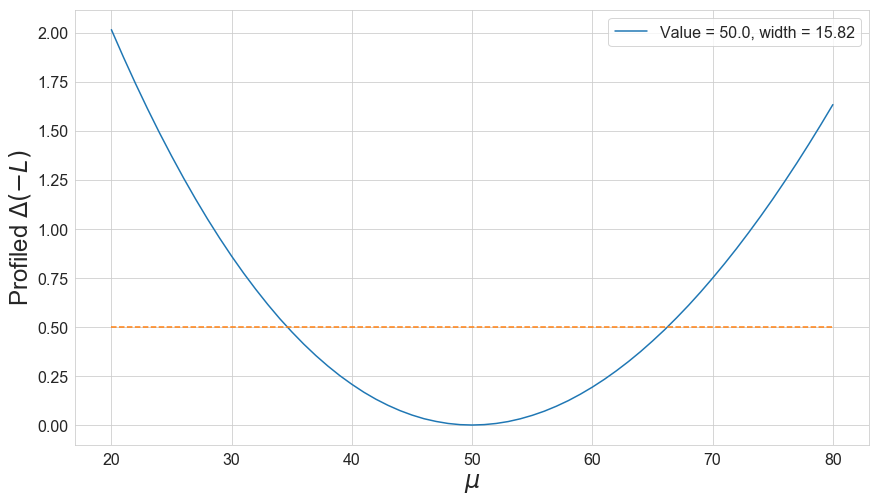

In [32]:
plot_likelihood(y-y.min())

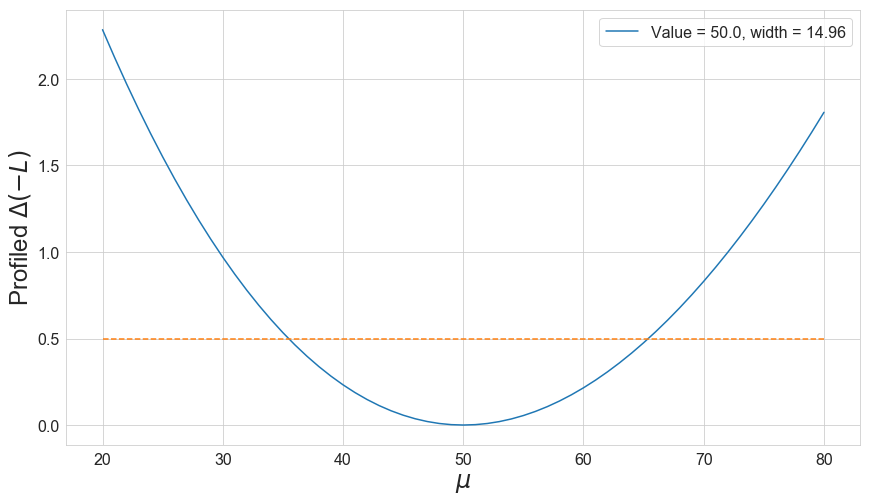

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [14]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [15]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,3,1.0,3,3,3,3,3,3,3,3,3,3,3
1,3,1.0,3,3,3,3,3,3,3,3,3,3,3
2,0,1.0,0,0,0,0,0,0,0,0,0,0,0
3,7,1.0,7,7,7,7,7,7,7,7,7,7,7
4,3,1.0,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999996,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999997,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999998,9,0.0,9,9,9,9,9,9,9,9,9,9,9


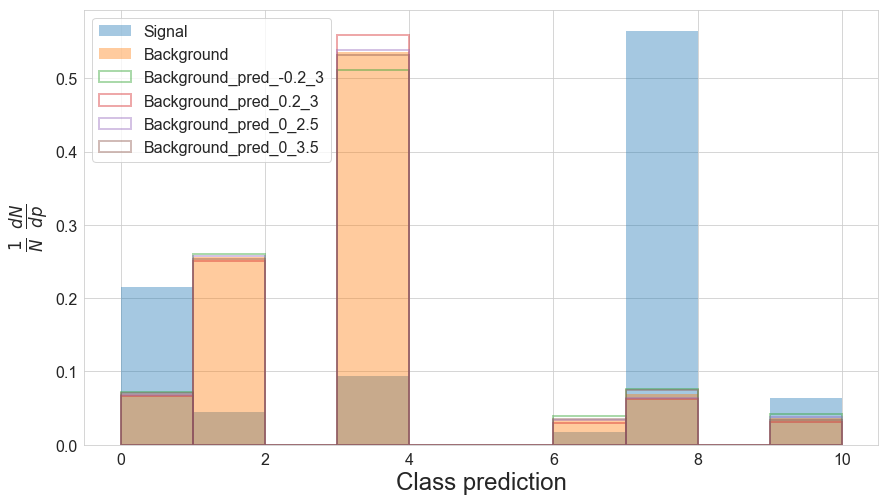

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([7.0712e-02, 2.6135e-01, 2.0000e-13, 5.1386e-01, 2.0000e-13, 2.0000e-13,
        3.9022e-02, 7.0246e-02, 2.0000e-13, 4.4810e-02])
tensor([7.2440e-02, 2.5971e-01, 2.0000e-13, 5.1066e-01, 2.0000e-13, 2.0000e-13,
        3.9134e-02, 7.5612e-02, 2.0000e-13, 4.2442e-02])
tensor([7.3838e-02, 2.5795e-01, 2.0000e-13, 5.0729e-01, 2.0000e-13, 2.0000e-13,
        3.9424e-02, 8.1330e-02, 2.0000e-13, 4.0172e-02])
tensor([6.7936e-02, 2.5734e-01, 2.0000e-13, 5.3845e-01, 2.0000e-13, 2.0000e-13,
        3.4268e-02, 6.3482e-02, 2.0000e-13, 3.8518e-02])
tensor([6.9664e-02, 2.5571e-01, 2.0000e-13, 5.3525e-01, 2.0000e-13, 2.0000e-13,
        3.4380e-02, 6.8848e-02, 2.0000e-13, 3.6150e-02])
tensor([7.1062e-02, 2.5394e-01, 2.0000e-13, 5.3188e-01, 2.0000e-13, 2.0000e-13,
        3.4670e-02, 7.4566e-02, 2.0000e-13, 3.3880e-02])
tensor([6.4564e-02, 2.5281e-01, 2.0000e-13, 5.6284e-01, 2.0000e-13, 2.0000e-13,
        2.9896e-02, 5.6994e-02, 2.0000e-13, 3.2894e-02])
tensor([6.6292e-02, 2.5117e-01, 2.0000e-1

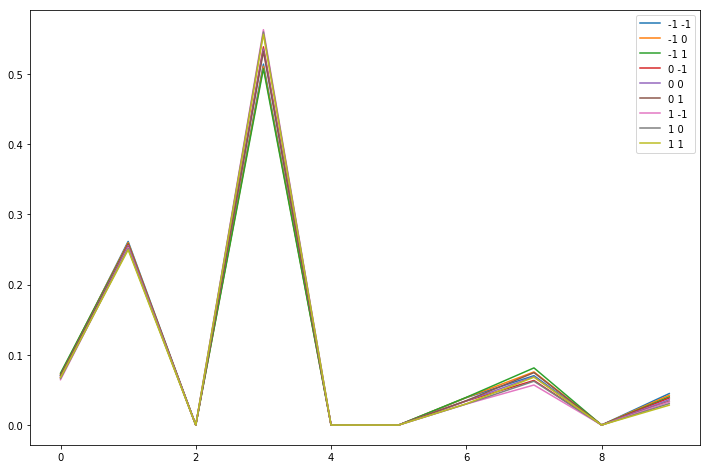

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [16]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [43]:
nll = to_np(nll)

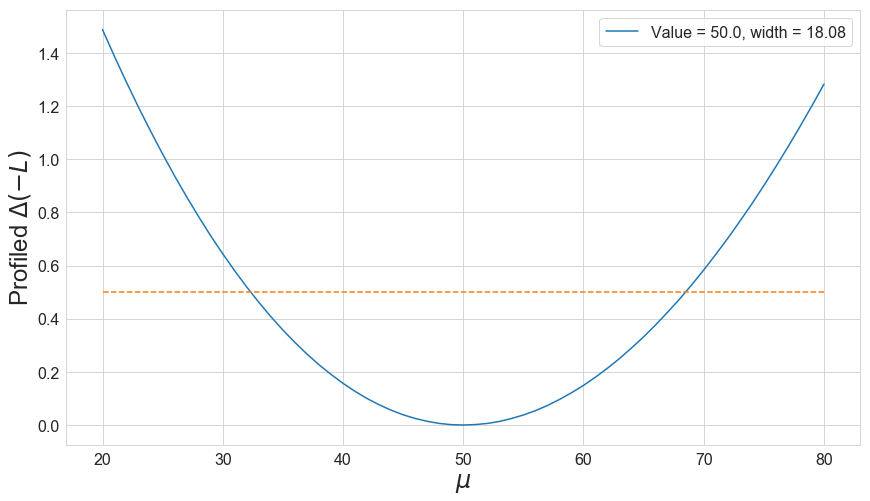

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.7960])
Linear regime: Mu 21.0, alpha tensor([1.7381])
Linear regime: Mu 22.0, alpha tensor([1.6801])
Linear regime: Mu 23.0, alpha tensor([1.6220])
Linear regime: Mu 24.0, alpha tensor([1.5637])
Linear regime: Mu 25.0, alpha tensor([1.5052])
Linear regime: Mu 26.0, alpha tensor([1.4466])
Linear regime: Mu 27.0, alpha tensor([1.3879])
Linear regime: Mu 28.0, alpha tensor([1.3290])
Linear regime: Mu 29.0, alpha tensor([1.2700])
Linear regime: Mu 30.0, alpha tensor([1.2109])
Linear regime: Mu 31.0, alpha tensor([1.1516])
Linear regime: Mu 32.0, alpha tensor([1.0922])
Linear regime: Mu 33.0, alpha tensor([1.0326])
Linear regime: Mu 67.0, alpha tensor([-1.0689])
Linear regime: Mu 68.0, alpha tensor([-1.1329])
Linear regime: Mu 69.0, alpha tensor([-1.1971])
Linear regime: Mu 70.0, alpha tensor([-1.2613])
Linear regime: Mu 71.0, alpha tensor([-1.3257])
Linear regime: Mu 72.0, alpha tensor([-1.3902])
Linear regime: Mu 73.0, alpha tensor([-1.4548])
Linear

In [47]:
nll = to_np(nll)

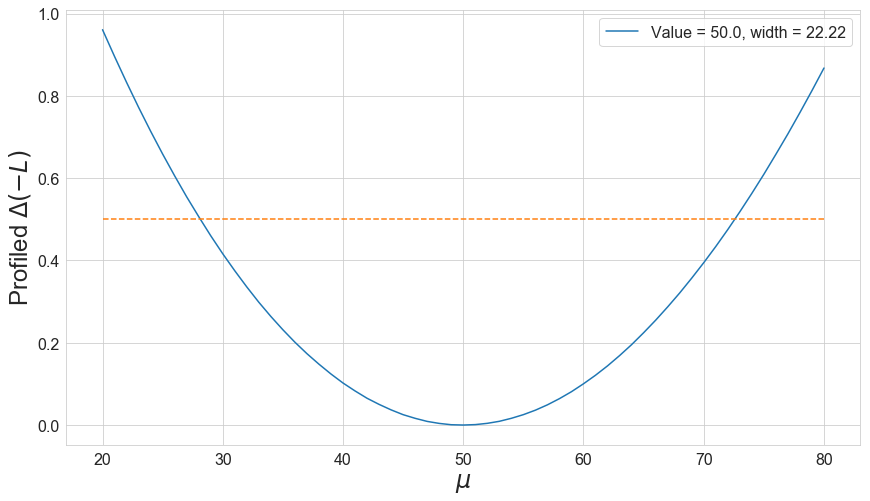

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3917,  1.6574])
Linear regime: Mu 21.0, alpha tensor([-0.3782,  1.6025])
Linear regime: Mu 22.0, alpha tensor([-0.3647,  1.5475])
Linear regime: Mu 23.0, alpha tensor([-0.3512,  1.4925])
Linear regime: Mu 24.0, alpha tensor([-0.3378,  1.4375])
Linear regime: Mu 25.0, alpha tensor([-0.3244,  1.3825])
Linear regime: Mu 26.0, alpha tensor([-0.3110,  1.3275])
Linear regime: Mu 27.0, alpha tensor([-0.2976,  1.2724])
Linear regime: Mu 28.0, alpha tensor([-0.2843,  1.2173])
Linear regime: Mu 29.0, alpha tensor([-0.2710,  1.1622])
Linear regime: Mu 30.0, alpha tensor([-0.2578,  1.1071])
Linear regime: Mu 31.0, alpha tensor([-0.2446,  1.0520])
Linear regime: Mu 68.0, alpha tensor([ 0.2361, -1.0178])
Linear regime: Mu 69.0, alpha tensor([ 0.2488, -1.0747])
Linear regime: Mu 70.0, alpha tensor([ 0.2616, -1.1315])
Linear regime: Mu 71.0, alpha tensor([ 0.2743, -1.1884])
Linear regime: Mu 72.0, alpha tensor([ 0.2869, -1.2454])
Linear regime: Mu 73.0, alpha t

In [50]:
nll = to_np(nll)

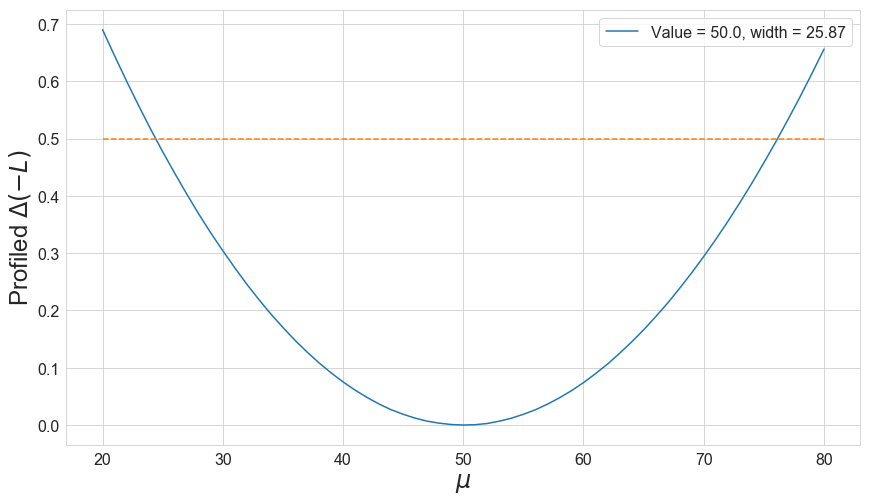

In [51]:
plot_likelihood(nll-nll.min())

## BM 3

In [17]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [18]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.4088,  1.1877])
Linear regime: Mu 21.0, alpha tensor([-0.3948,  1.1468])
Linear regime: Mu 22.0, alpha tensor([-0.3809,  1.1060])
Linear regime: Mu 23.0, alpha tensor([-0.3670,  1.0653])
Linear regime: Mu 24.0, alpha tensor([-0.3531,  1.0247])
Linear regime: Mu 78.0, alpha tensor([ 0.3781, -1.0092])
Linear regime: Mu 79.0, alpha tensor([ 0.3911, -1.0443])
Linear regime: Mu 80.0, alpha tensor([ 0.4042, -1.0789])


In [19]:
nll = to_np(nll)

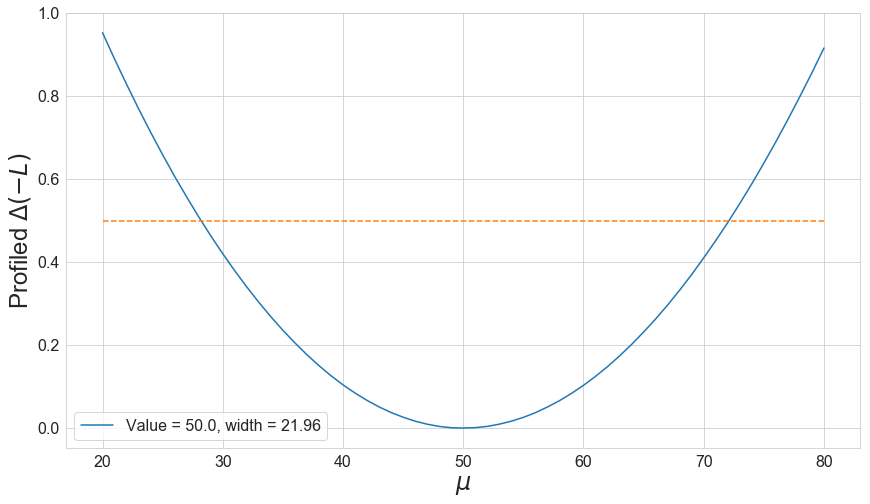

In [20]:
plot_likelihood(nll-nll.min())

## BM 4

In [21]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [22]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.4160,  1.2088, 26.5175])
Linear regime: Mu 21.0, alpha tensor([-0.4022,  1.1682, 25.6018])
Linear regime: Mu 22.0, alpha tensor([-0.3883,  1.1276, 24.6882])
Linear regime: Mu 23.0, alpha tensor([-0.3744,  1.0870, 23.7767])
Linear regime: Mu 24.0, alpha tensor([-0.3605,  1.0465, 22.8674])
Linear regime: Mu 25.0, alpha tensor([-0.3466,  1.0059, 21.9602])
Linear regime: Mu 26.0, alpha tensor([-0.3325,  0.9712, 21.0596])
Linear regime: Mu 27.0, alpha tensor([-0.3190,  0.9299, 20.1561])
Linear regime: Mu 28.0, alpha tensor([-0.3055,  0.8886, 19.2548])
Linear regime: Mu 29.0, alpha tensor([-0.2919,  0.8474, 18.3557])
Linear regime: Mu 30.0, alpha tensor([-0.2783,  0.8063, 17.4588])
Linear regime: Mu 31.0, alpha tensor([-0.2646,  0.7652, 16.5641])
Linear regime: Mu 32.0, alpha tensor([-0.2509,  0.7242, 15.6715])
Linear regime: Mu 33.0, alpha tensor([-0.2372,  0.6833, 14.7813])
Linear regime: Mu 34.0, alpha tensor([-0.2235,  0.6424, 13.8933])
Linear reg

In [23]:
nll = to_np(nll)

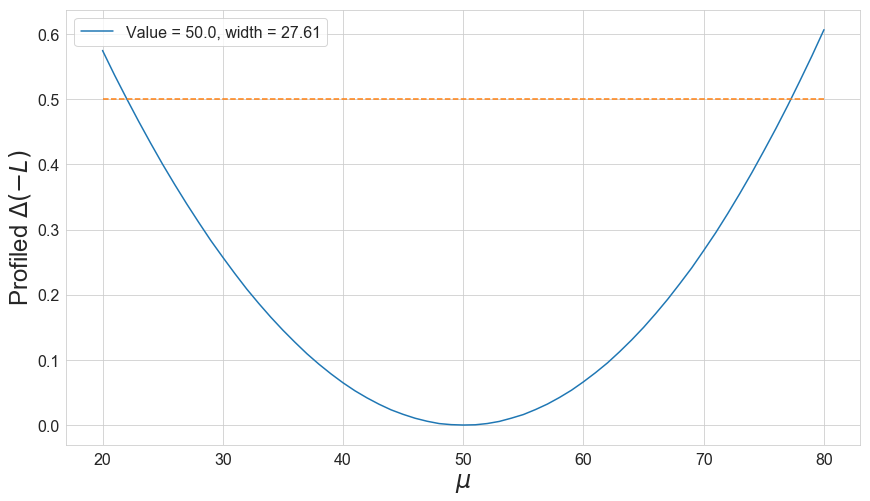

In [24]:
plot_likelihood(nll-nll.min())